In [11]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

ImportError: cannot import name 'Statevector' from 'qiskit' (/Users/danielleodigie/opt/anaconda3/lib/python3.9/site-packages/qiskit/__init__.py)

In [2]:
qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [4]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [6]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [8]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

In [40]:


import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile
from qiskit.extensions import Initialize


state = [1/np.sqrt(2), -1j/np.sqrt(2)]

def bell_pair(qc, x, y):
    qc.h(x)
    qc.cx(x,y)
    
def a_gates(qc, psi, x):
    qc.cx(psi, x)
    qc.h(psi)

def measure_and_send(qc, x, y):
    qc.barrier()
    qc.measure(x,0)
    qc.measure(y,1)
    
def b_gates(qc, qubit, crz, crx):
    qc.x(qubit).c_if(crx, 1)
    qc.z(qubit).c_if(crz, 1)

def initgate(state):
    
    init_gate = Initialize(state)
    init_gate.label = "init"
    reverse = init_gate.gates_to_uncompute()
    reverse.label = "reverse"
    return init_gate, reverse
    
    
def build_qteleportation(state):
    qr = QuantumRegister(3, name="q")
    crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
    teleportation_circuit = QuantumCircuit(qr, crz, crx)
    
    inits = initgate(state)
    
    teleportation_circuit.append(inits[0], [0])
    teleportation_circuit.barrier()
    
    bell_pair(teleportation_circuit, 1, 2)
    
    teleportation_circuit.barrier()
    a_gates(teleportation_circuit, 0, 1)
    
    measure_and_send(teleportation_circuit, 0, 1)
    
    teleportation_circuit.barrier() # Use barrier to separate steps
    b_gates(teleportation_circuit, 2, crz, crx)
    
    teleportation_circuit.append(inits[1], [2])
    
    cr_result = ClassicalRegister(1)
    teleportation_circuit.add_register(cr_result)
    teleportation_circuit.measure(2,2)
    
    return teleportation_circuit
    

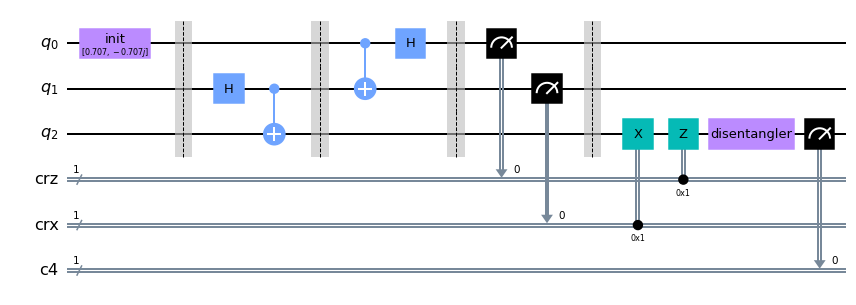

In [41]:
qc = build_qteleportation(state)

qc.draw("mpl")

{'0 0 1': 267, '0 1 0': 243, '0 0 0': 257, '0 1 1': 257}
[{'1': 524, '0': 500}, {'0': 524, '1': 500}, {'0': 1024}]


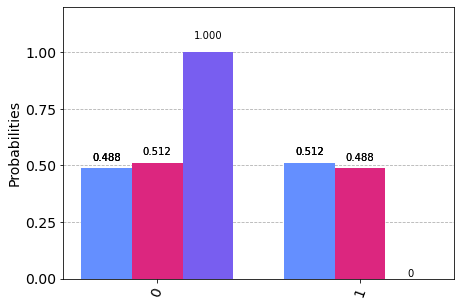

In [44]:
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
print(counts)
print(qubit_counts)
plot_histogram(qubit_counts)
